## Content
1. [Load data](#1.-Load-data)  
2. [Diving into data](#2.-Diving-into-data)  
3. [Data preprocessing](#3.-Data-preprocessing)  
4. [Training word2vec model](#4.-Training-word2vec-model)  

In [1]:
import numpy as np
import pandas as pd

from pprint import pprint
from tqdm import tqdm

IN_PATH = '../data/'
WORD_EMBEDDINGS_PATH = '../word_embeddings/'
MAX_NR_OF_COMMENTS = None
target_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

## 1. Load data

In [2]:
train_df = pd.read_csv(IN_PATH + 'train.csv', encoding='utf8')
test_df = pd.read_csv(IN_PATH + 'test.csv', encoding='utf8')

In [3]:
if MAX_NR_OF_COMMENTS is not None:
    print('MAX_NR_OF_COMMENTS: {}'.format(MAX_NR_OF_COMMENTS))
    train_df = train_df.head(MAX_NR_OF_COMMENTS)
    test_df = test_df.head(MAX_NR_OF_COMMENTS)

## 2. Diving into data

### 2.1 General info

In [4]:
print(train_df[0:5])

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


In [5]:
comment = train_df['comment_text'][0]
print(comment)

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


In [6]:
print(type(comment))

<type 'unicode'>


In [7]:
print(train_df.shape)
print(test_df.shape)

(159571, 8)
(153164, 2)


### 2.2 Data distribution

In [8]:
def comments_lengths_char(df):
    return [len(comment) for comment in df['comment_text']]

In [9]:
train_comments_lengths_chars = comments_lengths_char(train_df)
test_comments_lengths_chars = comments_lengths_char(test_df)

In [10]:
from nltk.tokenize import WordPunctTokenizer
word_punct_tokenizer = WordPunctTokenizer()

def comments_lengths_words(df):
    lengths = list()
    words = list()
    n = 0
    
    for comment in df['comment_text']:
        words.append([])
        comment_length = 0
        
        for word in word_punct_tokenizer.tokenize(comment):
            if word.isalpha():
                comment_length += 1
                words[n].append(word)
                
        lengths.append(comment_length)
        n += 1
        
    return (lengths, words)

In [11]:
(train_comments_lengths_words, train_comment_words) = comments_lengths_words(train_df)
(test_comments_lengths_words, test_comment_words) = comments_lengths_words(test_df)

In [12]:
comment_0_words = word_punct_tokenizer.tokenize(train_df['comment_text'][0])
filtered_comment_0_words = train_comment_words[0]

print(comment_0_words)
print(filtered_comment_0_words)

[u'Explanation', u'Why', u'the', u'edits', u'made', u'under', u'my', u'username', u'Hardcore', u'Metallica', u'Fan', u'were', u'reverted', u'?', u'They', u'weren', u"'", u't', u'vandalisms', u',', u'just', u'closure', u'on', u'some', u'GAs', u'after', u'I', u'voted', u'at', u'New', u'York', u'Dolls', u'FAC', u'.', u'And', u'please', u'don', u"'", u't', u'remove', u'the', u'template', u'from', u'the', u'talk', u'page', u'since', u'I', u"'", u'm', u'retired', u'now', u'.', u'89', u'.', u'205', u'.', u'38', u'.', u'27']
[u'Explanation', u'Why', u'the', u'edits', u'made', u'under', u'my', u'username', u'Hardcore', u'Metallica', u'Fan', u'were', u'reverted', u'They', u'weren', u't', u'vandalisms', u'just', u'closure', u'on', u'some', u'GAs', u'after', u'I', u'voted', u'at', u'New', u'York', u'Dolls', u'FAC', u'And', u'please', u'don', u't', u'remove', u'the', u'template', u'from', u'the', u'talk', u'page', u'since', u'I', u'm', u'retired', u'now']


In [13]:
def show_hists(x_train, x_test, values_name=''):
    fig, axs = plt.subplots(1, 2)
    plt.subplots_adjust(wspace=0.6)
    
    axs[0].hist(x_train)
    axs[0].set_xlabel('number of ' + values_name)
    axs[0].set_ylabel('frequency')
    axs[0].set_title('train set')
    
    axs[1].hist(x_test)
    axs[1].set_xlabel('number of ' + values_name)
    axs[1].set_ylabel('frequency')
    axs[1].set_title('test set')

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

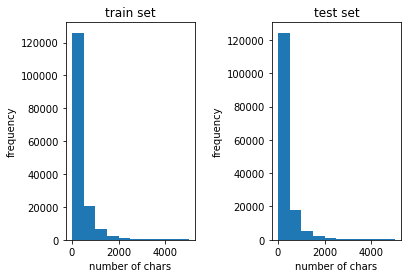

In [15]:
show_hists(train_comments_lengths_chars, test_comments_lengths_chars, 'chars')

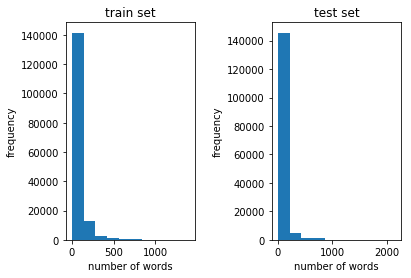

In [16]:
show_hists(train_comments_lengths_words, test_comments_lengths_words, 'words')

## 3. Data preprocessing

### 3.1 Tokenize-filter-lower

In [17]:
def tokenize_filter_lower(df):
    words = list()
    n = 0
    
    for comment in df['comment_text']:
        words.append([])        
        for word in word_punct_tokenizer.tokenize(comment):
            if word.isalpha():
                words[n].append(word.lower())
        n += 1
        
    return words

In [18]:
train_tokens = tokenize_filter_lower(train_df)
test_tokens = tokenize_filter_lower(test_df)

In [19]:
pprint(train_tokens[0][0:20])

[u'explanation',
 u'why',
 u'the',
 u'edits',
 u'made',
 u'under',
 u'my',
 u'username',
 u'hardcore',
 u'metallica',
 u'fan',
 u'were',
 u'reverted',
 u'they',
 u'weren',
 u't',
 u'vandalisms',
 u'just',
 u'closure',
 u'on']


### 3.2 Lemmatization

** Conversion from Penn Treebank tag to a simplified Wordnet tag is taken from ** https://nlpforhackers.io/wordnet-sentence-similarity/

In [20]:
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    """ Convert between a Penn Treebank tag to a simplified Wordnet tag """
    if tag.startswith('N'):
        return 'n'
 
    if tag.startswith('V'):
        return 'v'
 
    if tag.startswith('J'):
        return 'a'
 
    if tag.startswith('R'):
        return 'r'
 
    return 'v'

def lemmatization(tokens):   
    lemmas = list()
    n = 0
    pbar = tqdm(total=len(tokens))
    
    for token_row in tokens:
        lemmas.append([])
        for token in token_row:
            penn_tag = pos_tag([token])[0][1]
            wn_tag = penn_to_wn(penn_tag)
            lemma = lemmatizer.lemmatize(token, pos=wn_tag)
            lemmas[n].append(lemma)
        n += 1
        if n % 1000 == 0:
            pbar.update(1000)
    
    pbar.update(len(tokens) - 1000 * int(len(tokens)/1000))
    pbar.close()    
        
    return lemmas

In [21]:
train_lemmas = lemmatization(train_tokens)
test_lemmas = lemmatization(test_tokens)

100%|██████████| 153164/153164 [17:02<00:00, 142.35it/s]


In [22]:
train_lemmas[0][0:20]

[u'explanation',
 u'why',
 u'the',
 u'edits',
 u'make',
 u'under',
 u'my',
 u'username',
 u'hardcore',
 u'metallica',
 u'fan',
 u'be',
 u'revert',
 u'they',
 u'weren',
 u't',
 u'vandalism',
 u'just',
 u'closure',
 u'on']

### 3.3 Stopwords elimination

In [23]:
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words('english'))

def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token not in set(stopwords_set)]   
    return filtered_tokens

def stopwords_elimination(comments):
    return [remove_stopwords(comment) for comment in comments]

In [24]:
train_preprocessed = stopwords_elimination(train_lemmas)
test_preprocessed = stopwords_elimination(test_lemmas)

In [25]:
pprint(train_preprocessed[0])

[u'explanation',
 u'edits',
 u'make',
 u'username',
 u'hardcore',
 u'metallica',
 u'fan',
 u'revert',
 u'vandalism',
 u'closure',
 u'gas',
 u'vote',
 u'new',
 u'york',
 u'doll',
 u'fac',
 u'please',
 u'remove',
 u'template',
 u'talk',
 u'page',
 u'since',
 u'retire']


In [44]:
import json

def save_preprocessed_data(data, set_name):
    with open(IN_PATH + set_name, 'w') as fo:
        json.dump(data, fo)

In [45]:
save_preprocessed_data(train_preprocessed, 'train_preprocessed.json')

In [46]:
save_preprocessed_data(test_preprocessed, 'test_preprocessed.json')

## 4. Training word2vec model
A good tutorial can be found here: https://rare-technologies.com/word2vec-tutorial/  
Good links:  
- https://radimrehurek.com/gensim/models/word2vec.html
- http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/

In [39]:
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [40]:
model_sg = 0
model_size = 200
model_min_count = 2
model_negative = 5
model_window = 5

In [41]:
model = gensim.models.Word2Vec(train_comment_words + test_comment_words, sg=model_sg, size=model_size, 
                               min_count=model_min_count,
                               negative=model_negative, window=model_window,
                               workers=5)

2018-05-16 19:28:43,633 : INFO : collecting all words and their counts
2018-05-16 19:28:43,634 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-05-16 19:28:43,755 : INFO : PROGRESS: at sentence #10000, processed 688925 words, keeping 42375 word types
2018-05-16 19:28:43,879 : INFO : PROGRESS: at sentence #20000, processed 1366359 words, keeping 63569 word types
2018-05-16 19:28:44,005 : INFO : PROGRESS: at sentence #30000, processed 2030874 words, keeping 80498 word types
2018-05-16 19:28:44,134 : INFO : PROGRESS: at sentence #40000, processed 2720130 words, keeping 95520 word types
2018-05-16 19:28:44,260 : INFO : PROGRESS: at sentence #50000, processed 3388878 words, keeping 108511 word types
2018-05-16 19:28:44,387 : INFO : PROGRESS: at sentence #60000, processed 4092316 words, keeping 121111 word types
2018-05-16 19:28:44,520 : INFO : PROGRESS: at sentence #70000, processed 4773127 words, keeping 132764 word types
2018-05-16 19:28:44,653 : INFO : PROG

2018-05-16 19:29:17,680 : INFO : EPOCH 2 - PROGRESS: at 75.54% examples, 1099967 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:29:18,687 : INFO : EPOCH 2 - PROGRESS: at 83.07% examples, 1101711 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:29:19,687 : INFO : EPOCH 2 - PROGRESS: at 90.22% examples, 1100408 words/s, in_qsize 8, out_qsize 0
2018-05-16 19:29:20,691 : INFO : EPOCH 2 - PROGRESS: at 97.66% examples, 1101247 words/s, in_qsize 9, out_qsize 0
2018-05-16 19:29:20,987 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-05-16 19:29:20,994 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-05-16 19:29:20,996 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-05-16 19:29:21,000 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-05-16 19:29:21,001 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-05-16 19:29:21,002 : INFO : EPOCH - 2 : training on 20244573 raw words (15846451 eff

In [42]:
model.save('{}model_4/model_sg_{}_size_{}_min_count_{}_negative_{}_window_{}'.format(WORD_EMBEDDINGS_PATH, 
                                                                             model_sg, model_size,
                                                                             model_min_count,
                                                                             model_negative,
                                                                             model_window))

2018-05-16 19:33:22,909 : INFO : saving Word2Vec object under ../word_embeddings/model_4/model_sg_0_size_200_min_count_2_negative_5_window_5, separately None
2018-05-16 19:33:22,910 : INFO : storing np array 'vectors' to ../word_embeddings/model_4/model_sg_0_size_200_min_count_2_negative_5_window_5.wv.vectors.npy
2018-05-16 19:33:23,379 : INFO : not storing attribute vectors_norm
2018-05-16 19:33:23,379 : INFO : storing np array 'syn1neg' to ../word_embeddings/model_4/model_sg_0_size_200_min_count_2_negative_5_window_5.trainables.syn1neg.npy
2018-05-16 19:33:23,844 : INFO : not storing attribute cum_table
2018-05-16 19:33:26,389 : INFO : saved ../word_embeddings/model_4/model_sg_0_size_200_min_count_2_negative_5_window_5
